In [3]:
import sys
sys.path.append("../src")
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functions import get_corr_pairs, show_results, get_df_uniques
from sklearn.metrics import precision_score, roc_curve, auc, RocCurveDisplay 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import recall_score, classification_report, make_scorer
from sklearn.feature_selection import SelectKBest, chi2
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


train = pd.read_csv("../data/01_raw/attrition_train.csv")
test = pd.read_csv("../data/01_raw/attrition_test.csv")
test.drop(["index1"], axis=1, inplace=True)

## Aperçu de la data

In [4]:
train.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,38,No,Travel_Frequently,240,Research & Development,2,4,Life Sciences,1,803,...,4,80,0,17,2,3,15,7,4,12
1,52,No,Travel_Frequently,322,Research & Development,28,2,Medical,1,1401,...,2,80,1,24,3,2,5,3,0,2
2,28,No,Non-Travel,1476,Research & Development,1,3,Life Sciences,1,1315,...,1,80,3,10,6,3,9,8,7,5
3,43,No,Travel_Rarely,920,Research & Development,3,3,Life Sciences,1,1255,...,2,80,1,25,2,3,8,7,0,7
4,27,No,Non-Travel,443,Research & Development,3,3,Medical,1,850,...,3,80,3,0,6,2,0,0,0,0


In [5]:
train.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.0,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,...,1100.000000,1100.0,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,36.854545,804.234545,9.301818,2.907273,1.0,1026.404545,2.730909,66.011818,2.707273,2.064545,...,2.697273,80.0,0.785455,11.206364,2.780909,2.780909,7.070000,4.250000,2.186364,4.199091
std,9.039229,405.583238,8.093392,1.012453,0.0,598.712521,1.083564,20.374359,0.731298,1.115862,...,1.084338,0.0,0.848575,7.784761,1.309377,0.706269,6.147387,3.595094,3.234650,3.584848
min,18.000000,102.000000,1.000000,1.000000,1.0,4.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,460.500000,2.000000,2.000000,1.0,494.750000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,805.000000,7.000000,3.000000,1.0,1031.000000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,42.250000,1162.000000,14.000000,4.000000,1.0,1543.250000,4.000000,84.000000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1498.000000,29.000000,5.000000,1.0,2065.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,38.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


## Traitement des données manquantes

In [6]:
print(f"train shape : {train.shape}")
print(f"missing values : {train.isna().sum().sum()}")
#list(train.columns)

print(f"test shape : {test.shape}")
print(f"missing values : {test.isna().sum().sum()}")
#list(test.columns)

train shape : (1100, 35)
missing values : 0
test shape : (370, 34)
missing values : 0


In [7]:
train['Attrition'].value_counts()

No     922
Yes    178
Name: Attrition, dtype: int64

## Choix des colonnes (recherche de données pertinentes)

In [8]:
#train.dtypes

In [9]:
get_df_uniques(train)

,Features,Unique Number,Values
0,Age,43,"[38, 52, 28, 43, 27, 37, 29, 36, 55, 40, 57, 3..."
1,Attrition,2,"[No, Yes]"
2,BusinessTravel,3,"[Travel_Frequently, Non-Travel, Travel_Rarely]"
3,DailyRate,762,"[240, 322, 1476, 920, 443, 309, 459, 566, 1229..."
4,Department,3,"[Research & Development, Sales, Human Resources]"
5,DistanceFromHome,29,"[2, 28, 1, 3, 10, 24, 18, 4, 20, 6, 26, 12, 23..."
6,Education,5,"[4, 2, 3, 1, 5]"
7,EducationField,6,"[Life Sciences, Medical, Human Resources, Othe..."
8,EmployeeCount,1,[1]
9,EmployeeNumber,1100,"[803, 1401, 1315, 1255, 850, 1105, 1868, 407, ..."


On peut voir 3 colonnes qui ont seulement 1 valeur
EmployeeCount, Over18 et StandardHours
On pourra donc drop ces col (tâche efféctué dans le pipe preprocessing)

## Choix des features

In [10]:
get_corr_pairs(train,10)

0.95098 ('MonthlyIncome', 'JobLevel')
0.78240 ('JobLevel', 'TotalWorkingYears')
0.77648 ('YearsWithCurrManager', 'YearsAtCompany')
0.77513 ('PercentSalaryHike', 'PerformanceRating')
0.76826 ('MonthlyIncome', 'TotalWorkingYears')
0.76797 ('YearsInCurrentRole', 'YearsAtCompany')
0.72998 ('YearsWithCurrManager', 'YearsInCurrentRole')
0.67252 ('TotalWorkingYears', 'Age')
0.64597 ('YearsAtCompany', 'TotalWorkingYears')
0.58804 ('YearsSinceLastPromotion', 'YearsAtCompany')


In [11]:
y = train["Attrition"]
X = train.drop([
    "Attrition", "EmployeeCount", "Over18", 
    "StandardHours", "JobLevel", "YearsInCurrentRole", 
    "YearsWithCurrManager"
], axis=1)

test = test.drop([
    "EmployeeCount", "Over18", "StandardHours", "JobLevel", 
    "YearsInCurrentRole", "YearsWithCurrManager"
], axis=1)

Ces variables étant trop corrélées, elles sont retiré des features

## Gestion des différents types de variables

In [12]:
cat_cols = X.select_dtypes(include="O").columns
num_cols = X.select_dtypes(exclude="O").columns


## Séparation des sets d'entrainement et de test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

## Création des pipelines
### Preprocessing
OneHot encoding des variables catégorielles.

In [14]:
cat_trans = OneHotEncoder()
num_trans = SimpleImputer()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_trans, cat_cols),
        ('num', num_trans, num_cols)
    ])

# LogisticRegression
La métrique utilisé ici pour évalué le modèle est le recall score. On considère que le plus important dans ce cas précis est de minimiser le nombre de faux négatifs.


In [15]:
logit = LogisticRegression()

logit_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', logit)]
)

_ = logit_pipe.fit(X_train, y_train)

In [16]:
logit_pred = logit_pipe.predict(X_test)
show_results(y_test, logit_pred)

recall score (Yes) : 0.0
True Negatives  :  95
False Positives :  0
False Negatives :  15
True Positives  :  0


In [17]:
print("Aperçu des autres métriques disponibles :\n")
print(classification_report(y_test, logit_pred))

Aperçu des autres métriques disponibles :

              precision    recall  f1-score   support

          No       0.86      1.00      0.93        95
         Yes       0.00      0.00      0.00        15

    accuracy                           0.86       110
   macro avg       0.43      0.50      0.46       110
weighted avg       0.75      0.86      0.80       110



## Amélioration du modèle
La répartition des valeurs cibles ("Yes", "No"), n'étant pas équitable, l'utilisation du paramêtre class_weight="balanced" s'avère nécessaire.

In [18]:
logit_2 = LogisticRegression(class_weight="balanced", solver="liblinear", penalty= 'l1', C=.4)

logit_2_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', logit_2)]
)

_ = logit_2_pipe.fit(X_train, y_train)

logit_2_pred = logit_2_pipe.predict(X_test)
print('Avec predict() : \n')
show_results(y_test, logit_2_pred)
print("\n")

threshold = 0.55
logit_proba = logit_2_pipe.predict_proba(X_test)
logit_proba = logit_2_pipe.classes_[np.argmax(logit_proba > threshold, axis=1)]
print(f'Avec predict_proba() : \n(Threshold = {threshold})\n')
show_results(y_test, logit_proba)

Avec predict() : 

recall score (Yes) : 0.9333333333333333
True Negatives  :  82
False Positives :  13
False Negatives :  1
True Positives  :  14


Avec predict_proba() : 
(Threshold = 0.55)

recall score (Yes) : 0.9333333333333333
True Negatives  :  84
False Positives :  11
False Negatives :  1
True Positives  :  14


On remarque que l'utilisation de predict_proba avec une modification du seuil n'améliore pas la métrique ciblée, mais cela réduit légérement le nombre de faux positifs.

### Évaluation des prédictions avec la courbe ROC

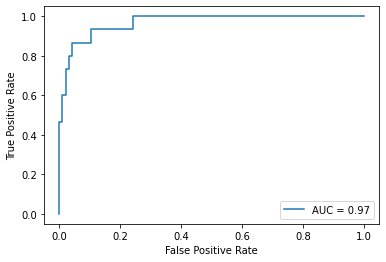

In [39]:
y_proba = logit_2_pipe.predict_proba(X_test)
y_proba_df = pd.DataFrame(y_proba)
y_proba_yes = y_proba_df[1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_yes, pos_label='Yes')
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

## prédictions sur test.csv

In [20]:
# Récupération des probabilités de départ
test_proba = logit_2_pipe.predict_proba(test)
# Modification du seuil
test_proba_pred = logit_2_pipe.classes_[np.argmax(test_proba > threshold, axis=1)]

test["AttritionPredict"] = pd.Series(test_proba_pred)

prob = pd.DataFrame(test_proba)
test["AttritionScore"] = prob[1]

final = test[['EmployeeNumber', 'AttritionScore', 'AttritionPredict']]

final.to_csv("test_predict.csv")

final["AttritionPredict"].value_counts()

No     283
Yes     87
Name: AttritionPredict, dtype: int64

In [21]:
final.head()

,EmployeeNumber,AttritionScore,AttritionPredict
0,1,0.920216,Yes
1,2,0.302807,No
2,7,0.584931,Yes
3,8,0.335488,No
4,20,0.135680,No


Nous essayons de réduire au maximum le nombre de personnes qui ne seront pas détectés avant de quitter l'entreprise.

On considère le taux de faux négatif plus important que le taux de faux positif.

La taille optimale d'une session serait 87 personnes (groupe divisé en deux sessions)

# RidgeClassifierCV

In [22]:

ridge = RidgeClassifierCV(alphas=[0.1,10,100,450], class_weight="balanced", normalize=True) 

ridge_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', ridge)]
)

_ = ridge_pipe.fit(X_train, y_train)

ridge_pred = ridge_pipe.predict(X_test)
show_results(y_test, ridge_pred)

recall score (Yes) : 0.9333333333333333
True Negatives  :  81
False Positives :  14
False Negatives :  1
True Positives  :  14


# LightGBM

In [23]:
lgbm = LGBMClassifier(class_weight="balanced")

lgbm_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
#    ('feature_select', feature_select),
    ('model', lgbm)]
)

_ = lgbm_pipe.fit(X_train, y_train)

In [24]:
lgbm_pred = lgbm_pipe.predict(X_test)

show_results(y_test, lgbm_pred)

recall score (Yes) : 0.6666666666666666
True Negatives  :  90
False Positives :  5
False Negatives :  5
True Positives  :  10


In [25]:
lgbm_params = {
    'boosting_type': ['gbdt', "dart", "goss"],
    'learning_rate': [.1*i for i in range(1,5)],
    'min_child_samples': [10*i for i in range(1,5)],
    'num_leaves': [5*i for i in range(1,5)],
    'objective': ['binary'],
    'class_weight': ["balanced"]
    }

grid_lgbm = GridSearchCV(lgbm, param_grid=lgbm_params, scoring=make_scorer(recall_score))

grid_lgbm_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', grid_lgbm)]
)
_ = grid_lgbm_pipe.fit(X_train, y_train)

In [26]:
grid_lgbm_pred = grid_lgbm_pipe.predict(X_test)

# best_params_ : {
#  'boosting_type': 'gbdt',
#  'class_weight': 'balanced',
#  'learning_rate': 0.1,
#  'min_child_samples': 10,
#  'num_leaves': 5,
#  'objective': 'binary'}
show_results(y_test, grid_lgbm_pred)

recall score (Yes) : 0.8666666666666667
True Negatives  :  85
False Positives :  10
False Negatives :  2
True Positives  :  13


# DecisionTreeClassifier

In [27]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=0)

tree_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', model)]
)

_ = tree_pipeline.fit(X_train, y_train)


In [28]:
tree_pred = tree_pipeline.predict(X_test)
show_results(y_test, tree_pred)

recall score (Yes) : 0.6
True Negatives  :  86
False Positives :  9
False Negatives :  6
True Positives  :  9


# GridSearchCV(RandomForest)

In [29]:
model = RandomForestClassifier(class_weight='balanced',random_state=0)

param_grid = { 
    'n_estimators': [100, 150, 200],
    'min_samples_leaf' :[5, 10, 20]
}
cv_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring=make_scorer(recall_score))

rf_cv_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', cv_search)],
)

_ = rf_cv_pipeline.fit(X_train, y_train)

In [30]:
rf_pred = rf_cv_pipeline.predict(X_test)
show_results(y_test, rf_pred)

recall score (Yes) : 0.5333333333333333
True Negatives  :  89
False Positives :  6
False Negatives :  7
True Positives  :  8


# BaggingClassifier

In [31]:
estimators = [
    logit_2,
    lgbm,
    grid_lgbm,
    ridge,
]

for estimator in estimators:

    bag = BaggingClassifier(
        base_estimator=estimator, random_state=1, n_jobs=-1
    )

    bag_pipe = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model', bag)]
    )

    _ = bag_pipe.fit(X_train, y_train)

    bag_pred = bag_pipe.predict(X_test)
    print(f"\nestimator : {estimator}\n")
    show_results(y_test, bag_pred)


estimator : LogisticRegression(C=0.4, class_weight='balanced', penalty='l1',
                   solver='liblinear')

recall score (Yes) : 0.9333333333333333
True Negatives  :  81
False Positives :  14
False Negatives :  1
True Positives  :  14

estimator : LGBMClassifier(class_weight='balanced')

recall score (Yes) : 0.6
True Negatives  :  93
False Positives :  2
False Negatives :  6
True Positives  :  9

estimator : GridSearchCV(estimator=LGBMClassifier(class_weight='balanced'),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'class_weight': ['balanced'],
                         'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4],
                         'min_child_samples': [10, 20, 30, 40],
                         'num_leaves': [5, 10, 15, 20],
                         'objective': ['binary']},
             scoring=make_scorer(recall_score))

recall score (Yes) : 0.8666666666666667
True Negatives  :  86
False Positives :  9
False Ne

On remarque que le BaggingClassifier obtient des résultats au mieux égaux aux résultat des modèles vu précédemment. 
Il est possible que l'on soit passé à côté d'un paramètre clé.

# XGBClassifier

In [32]:
model = XGBClassifier(random_state=0, learning_rate=0.02, objective='binary:hinge', booster='dart')

xgb_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', model)]
)

_ = xgb_pipeline.fit(X_train, y_train)

In [33]:
xgb_pred = xgb_pipeline.predict(X_test)
show_results(y_test, xgb_pred)

recall score (Yes) : 0.4
True Negatives  :  94
False Positives :  1
False Negatives :  9
True Positives  :  6


### Récapitulatif

Plusieurs tailles ont été testé pour le split des données de test et d'entrainement. La taille de l'échantillon de test a été fixé à 10%, avec amélioration des prédictions tout en gardant un échantillon de test de taille suffisante.
Cela est surement dut au fait que l'échantillon soit assez restreint.

# Conclusion 

Après test de multiple modèles, il s'avère que le LogisticRegression est le modèle qui semble convenir le mieux à nos données.